In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2024-03-14 14:09:14.799094: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 2

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

2024-03-14 14:09:23.091832: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-14 14:09:23.093351: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 1,092
Trainable params: 1,092
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


2024-03-14 14:09:24.812542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 14:09:24.924670: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


3/3 [==============================] - ETA: 0s - loss: 1.0596 - accuracy: 0.5128
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5


2024-03-14 14:09:26.579922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 425ms/step - loss: 1.0596 - accuracy: 0.5128 - val_loss: 0.8287 - val_accuracy: 0.5055
Epoch 2/1000
1/3 [=========>....................] - ETA: 0s - loss: 0.9759 - accuracy: 0.5391
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
3/3 [==============================] - 0s 78ms/step - loss: 0.9990 - accuracy: 0.5385 - val_loss: 0.7170 - val_accuracy: 0.5275
Epoch 3/1000
1/3 [=========>....................] - ETA: 0s - loss: 0.9944 - accuracy: 0.5000
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
3/3 [==============================] - 0s 80ms/step - loss: 0.8989 - accuracy: 0.5604 - val_loss: 0.6437 - val_accuracy: 0.5275
Epoch 4/1000
1/3 [=========>....................] - ETA: 0s - loss: 0.7913 - accuracy: 0.5938
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
3/3 [==============================] - 0s 61ms/step - loss: 0.8760 - accuracy: 0.5604 - val_loss: 0.5922 

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 43ms/step - loss: 0.0366 - accuracy: 0.9890


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 267ms/step
[0.00120882 0.99879116]
1


2024-03-14 14:10:04.835898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


# Confusion matrix

3/3 [==============================] - 0s 14ms/step


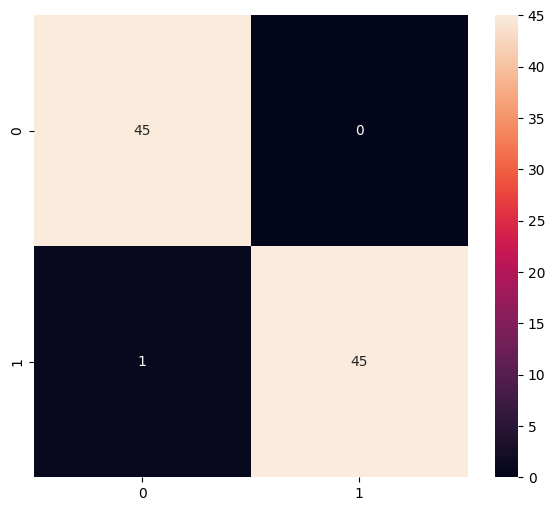

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       1.00      0.98      0.99        46

    accuracy                           0.99        91
   macro avg       0.99      0.99      0.99        91
weighted avg       0.99      0.99      0.99        91



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

2024-03-14 14:10:06.552534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,42]
	 [[{{node input_1}}]]
2024-03-14 14:10:06.645674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,42]
	 [[{{node inputs}}]]
2024-03-14 14:10:06.672270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,42]
	 [[{{node input_1}}]]
2024-03-14 14:1

INFO:tensorflow:Assets written to: /var/folders/gg/swd8dh_d3l12lvw08z_4b46m0000gn/T/tmpkj7gqnrj/assets


INFO:tensorflow:Assets written to: /var/folders/gg/swd8dh_d3l12lvw08z_4b46m0000gn/T/tmpkj7gqnrj/assets
2024-03-14 14:10:11.440018: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-03-14 14:10:11.440375: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-03-14 14:10:11.447120: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/gg/swd8dh_d3l12lvw08z_4b46m0000gn/T/tmpkj7gqnrj
2024-03-14 14:10:11.448967: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-03-14 14:10:11.448984: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/gg/swd8dh_d3l12lvw08z_4b46m0000gn/T/tmpkj7gqnrj
2024-03-14 14:10:11.461572: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-03-14 14:10:11.551589: I tensorflow/cc/saved_model/loader.cc:215] Running initialization

6456

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 670 µs, sys: 553 µs, total: 1.22 ms
Wall time: 714 µs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.1642004 0.8357996]
1
